This colab implements the [Symplectic Gradient Adjustment](http://proceedings.mlr.press/v80/balduzzi18a/balduzzi18a.pdf) (SGA) algorithm, inside the class ```SymplecticOptimizer```. It then applies this optimizer to two different experiments:
* using a GAN to learn a 4 by 4 mixture of Gaussians;
* using a GAN to learn 75 dimensional Gaussian.

All experiments below run in 5-10 minutes with a GPU, but can of course be much slower on CPU.

Use this link to run this notebook in colab:
https://colab.research.google.com/github/deepmind/symplectic-gradient-adjustment/blob/master/Symplectic_Gradient_Adjustment.ipynb

>[Experiment 1:  Learning a 4 by 4 mixture of Gaussian in 2D](#scrollTo=renqbkQ7ELzO)

>[Experiment 2: Learning a high dimensional Gaussian](#scrollTo=fJz9rggWDI0x)



In [5]:
!pip install dm-sonnet
!pip install 'kfac[tensorflow]' 

In [6]:
#@title Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import numpy as np
import sonnet as snt
import tensorflow as tf 
import kfac

import matplotlib.pyplot as plt
import scipy as sp


In [7]:
#@title Defining the SGA Optimiser

def list_divide_scalar(xs, y):
  return [x / y for x in xs]


def list_subtract(xs, ys):
  return [x - y for (x, y) in zip(xs, ys)]


def jacobian_vec(ys, xs, vs):
  return kfac.utils.fwd_gradients(
      ys, xs, grad_xs=vs, stop_gradients=xs)


def jacobian_transpose_vec(ys, xs, vs):
  dydxs = tf.gradients(ys, xs, grad_ys=vs, stop_gradients=xs)
  dydxs = [
      tf.zeros_like(x) if dydx is None else dydx for x, dydx in zip(xs, dydxs)
  ]
  return dydxs


def _dot(x, y):
  dot_list = []
  for xx, yy in zip(x, y):
    dot_list.append(tf.reduce_sum(xx * yy))
  return tf.add_n(dot_list)


class SymplecticOptimizer(tf.train.Optimizer):
  """Optimizer that corrects for rotational components in gradients."""

  def __init__(self,
               learning_rate,
               reg_params=1.,
               use_signs=True,
               use_locking=False,
               name='symplectic_optimizer'):
    super(SymplecticOptimizer, self).__init__(
        use_locking=use_locking, name=name)
    self._gd = tf.train.RMSPropOptimizer(learning_rate)
    self._reg_params = reg_params
    self._use_signs = use_signs

  def compute_gradients(self,
                        loss,
                        var_list=None,
                        gate_gradients=tf.train.Optimizer.GATE_OP,
                        aggregation_method=None,
                        colocate_gradients_with_ops=False,
                        grad_loss=None):
    return self._gd.compute_gradients(loss, var_list, gate_gradients,
                                      aggregation_method,
                                      colocate_gradients_with_ops, grad_loss)

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    grads, vars_ = zip(*grads_and_vars)
    n = len(vars_)
    h_v = jacobian_vec(grads, vars_, grads)
    ht_v = jacobian_transpose_vec(grads, vars_, grads)
    at_v = list_divide_scalar(list_subtract(ht_v, h_v), 2.)
    if self._use_signs:
      grad_dot_h = _dot(grads, ht_v)
      at_v_dot_h = _dot(at_v, ht_v)
      mult = grad_dot_h * at_v_dot_h
      lambda_ = tf.sign(mult / n + 0.1) * self._reg_params
    else:
      lambda_ = self._reg_params
    apply_vec = [(g + lambda_ * ag, x)
                 for (g, ag, x) in zip(grads, at_v, vars_)
                 if at_v is not None]
    return self._gd.apply_gradients(apply_vec, global_step, name)


In [8]:
#@title An MLP Sonnet module

class MLP(snt.AbstractModule):
  """An MLP with hidden layers of the same width as the input."""

  def __init__(self, depth, hidden_size, out_dim, name='SimpleNet'):
    super(MLP, self).__init__(name=name)
    self._depth = depth
    self._hidden_size = hidden_size
    self._out_dim = out_dim

  def _build(self, input):
    h = input
    for i in range(self._depth):
      h = tf.nn.relu(snt.Linear(self._hidden_size)(h))
    return snt.Linear(self._out_dim)(h)


In [9]:
#@title Build Graph to train a GAN

def reset_and_build_graph(
    depth, width, x_real_builder, z_dim, batch_size, learning_rate, mode):
  tf.reset_default_graph()

  x_real = x_real_builder(batch_size)
  x_dim = x_real.get_shape().as_list()[1]
  generator = MLP(depth, width, x_dim, 'generator')
  discriminator = MLP(depth, width, 1, 'discriminator')
  z = tf.random_normal([batch_size, z_dim])
  x_fake = generator(z)
  disc_out_real = discriminator(x_real)
  disc_out_fake = discriminator(x_fake)

  # Loss
  disc_loss_real = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_real, labels=tf.ones_like(disc_out_real)))
  disc_loss_fake = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.zeros_like(disc_out_fake)))
  disc_loss = disc_loss_real + disc_loss_fake

  gen_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(
          logits=disc_out_fake, labels=tf.ones_like(disc_out_fake)))
  gen_vars = generator.variable_scope.trainable_variables()
  disc_vars = discriminator.variable_scope.trainable_variables()
  # Compute gradients
  xs = disc_vars + gen_vars
  disc_grads = tf.gradients(disc_loss, disc_vars)
  gen_grads = tf.gradients(gen_loss, gen_vars)
  Xi = disc_grads + gen_grads
  apply_vec = list(zip(Xi, xs))

  if mode == 'RMS':
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
  elif mode == 'SGA':
    optimizer = SymplecticOptimizer(learning_rate)
  else:
    raise ValueError('Mode %s not recognised' % mode)

  with tf.control_dependencies([g for (g, v) in apply_vec]):
    train_op = optimizer.apply_gradients(apply_vec)

  init = tf.global_variables_initializer()
  
  return train_op, x_fake, z, init, disc_loss, gen_loss


# Experiment 1:  Learning a 4 by 4 mixture of Gaussian in 2D

In [10]:
#@title Defining the functions for the experiment

def kde(mu, tau, bbox=None, xlabel="", ylabel="", cmap='Blues'):
    values = np.vstack([mu, tau])
    kernel = sp.stats.gaussian_kde(values)

    fig, ax = plt.subplots()
    ax.axis(bbox)
    ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:300j, bbox[2]:bbox[3]:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)
    plt.show()


def train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim,
          n_iter=10001, n_save=2000):
  bbox = [-2, 2, -2, 2]
  batch_size = x_fake.get_shape()[0].value
  ztest = [np.random.randn(batch_size, z_dim) for i in range(10)]

  with tf.Session() as sess:
    sess.run(init)

    for i in range(n_iter):
      disc_loss_out, gen_loss_out, _ = sess.run(
          [disc_loss, gen_loss, train_op])
      if i % n_save == 0:
        print('i = %d, discriminant loss = %.4f, generator loss =%.4f' %
              (i, disc_loss_out, gen_loss_out))
        x_out = np.concatenate(
            [sess.run(x_fake, feed_dict={z: zt}) for zt in ztest], axis=0)
        kde(x_out[:, 0], x_out[:, 1], bbox=bbox)
    
def learn_mixture_of_gaussians(mode):
  print(mode)
  def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    return mus + sigma*tf.random_normal([batch_size, 2])*.2
  
  z_dim = 64
  train_op, x_fake, z, init, disc_loss, gen_loss = reset_and_build_graph(
      depth=6, width=384, x_real_builder=x_real_builder, z_dim=z_dim,
      batch_size=256, learning_rate=1e-4, mode=mode)

  train(train_op, x_fake, z, init, disc_loss, gen_loss, z_dim)


RMS
i = 0, discriminant loss = 1.3859, generator loss =0.6931


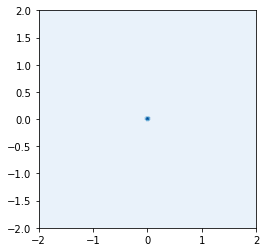

i = 2000, discriminant loss = 1.1366, generator loss =0.9848


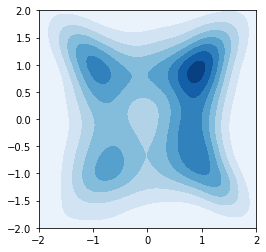

i = 4000, discriminant loss = 0.6400, generator loss =2.3771


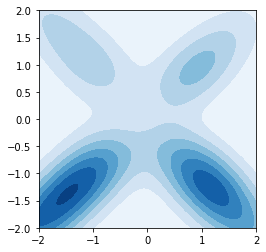

i = 6000, discriminant loss = 0.5251, generator loss =2.0296


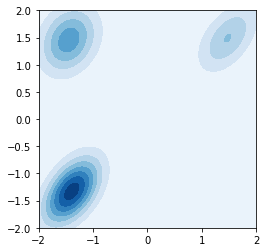

i = 8000, discriminant loss = 0.5816, generator loss =1.8950


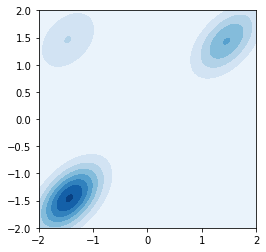

i = 10000, discriminant loss = 0.5796, generator loss =2.1798


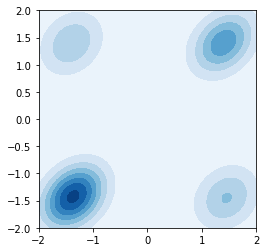

In [11]:
# Use plain RmsProp to optimise the GAN parameters.
# This experiment demonstratest mode collapse in traditional GAN training.
learn_mixture_of_gaussians('RMS')


SGA
i = 0, discriminant loss = 1.3478, generator loss =0.6922


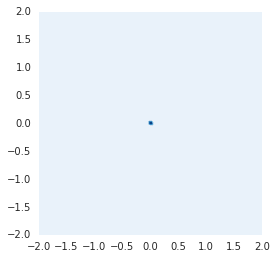

i = 2000, discriminant loss = 1.3518, generator loss =0.7154


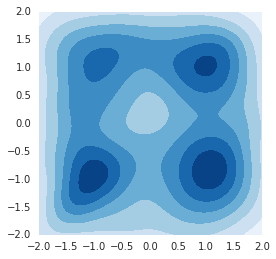

i = 4000, discriminant loss = 1.3396, generator loss =0.7204


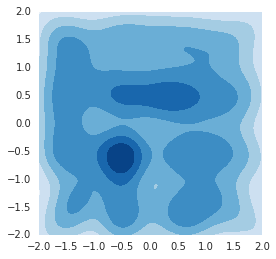

i = 6000, discriminant loss = 1.3835, generator loss =0.6949


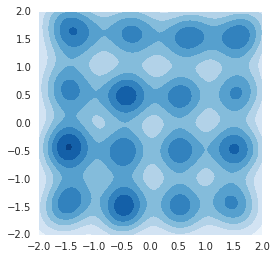

i = 8000, discriminant loss = 1.3852, generator loss =0.6934


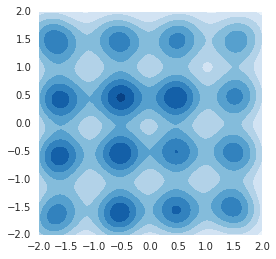

i = 10000, discriminant loss = 1.3857, generator loss =0.6932


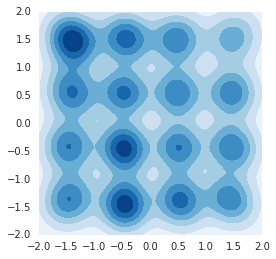

In [0]:
# Use Symplectic Gradient Adjustment to optimise the GAN parameters.
# With SGA, all modes are produced by the trained GAN.
learn_mixture_of_gaussians('SGA')


# Experiment 2: Learning a high dimensional Gaussian

Learning a high dimensional Gaussian (dimension 75 in the experiment below) using a GAN is an experiment that was proposed in 'A Classification–Based Study of Covariate Shift in GAN Distributions' by Santurkar et al. (https://arxiv.org/pdf/1711.00970.pdf).

In the experiments below, the graphs plot all 75 singular values, in decreasing order, of the covariance matrix of the data generated by the GAN.

In [0]:
#@title Defining the functions for the experiment

def compute_eigenvalue(sess, x, n_pts, title):
  """Computes the singular values of the covariance matrix of x.
  
  The singular values are displayed in decreasing order in a plot.
  
  Args:
    sess: a Session object.
    x: a Tensor of shape ```(batch_size, x_dim)```
    n_pts: an int; the number of points used to compute the covariance matrix
    title: a string; the title of the displayed plot
  """
  batch_size, x_dim = x.get_shape().as_list()
  # Round n_pts to the next multiple of batch_size
  n_runs = (n_pts + batch_size - 1) // batch_size
  n_pts = n_runs * batch_size
  mean = np.zeros([x_dim])
  moment = np.zeros([x_dim, x_dim])
  for _ in range(n_runs):
    x_out = sess.run(x)
    mean += np.sum(x_out, axis=0)
    moment += np.matmul(x_out.transpose(), x_out)
  mean /= n_pts
  moment /= n_pts
  mean_2 = np.expand_dims(mean, 0)
  cov = moment - np.matmul(mean_2.transpose(), mean_2)
  u, s, vh = np.linalg.svd(cov)
  plt.plot(s)
  plt.title(title)
  plt.show()


def train(train_op, x_fake, init, disc_loss, gen_loss):
  n_iter = 20001
  n_save = 2000

  with tf.Session() as sess:
    sess.run(init)

    compute_eigenvalue(sess, x_fake, 2**20, 'BEFORE TRAINING')

    for i in range(n_iter):
      sess.run(train_op)
      disc_loss_out, gen_loss_out = sess.run([disc_loss, gen_loss])
      if i % n_save == 0:
        print('i = %d, discriminant loss = %.4f, generator loss =%.4f' %
              (i, disc_loss_out, gen_loss_out))
        compute_eigenvalue(sess, x_fake, 2**15, 'iter %d' % i)

    compute_eigenvalue(sess, x_fake, 2**20, 'AFTER TRAINING')


def high_dim_gaussian_experiment(mode):
  print(mode)

  x_dim = 75
  def x_real_builder(batch_size):
    return tf.random_normal([batch_size, x_dim])

  train_op, x_fake, unused_z, init, disc_loss, gen_loss = reset_and_build_graph(
      depth=2, width=200, x_real_builder=x_real_builder, z_dim=200,
      batch_size=64, learning_rate=2e-4, mode=mode)

  train(train_op, x_fake, init, disc_loss, gen_loss)


RMS


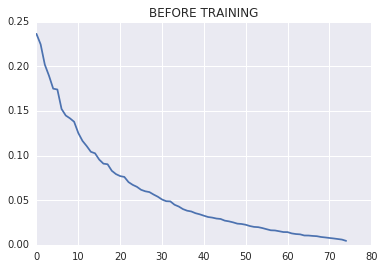

i = 0, discriminant loss = 1.3330, generator loss =0.6784


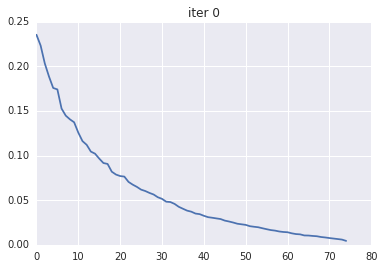

i = 2000, discriminant loss = 1.4357, generator loss =0.6665


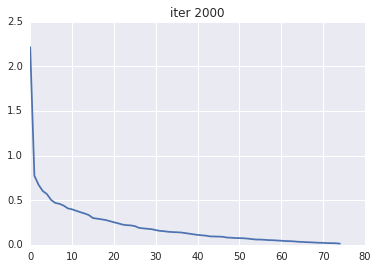

i = 4000, discriminant loss = 1.4493, generator loss =0.6590


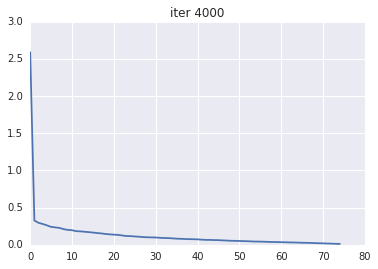

i = 6000, discriminant loss = 1.3671, generator loss =0.7225


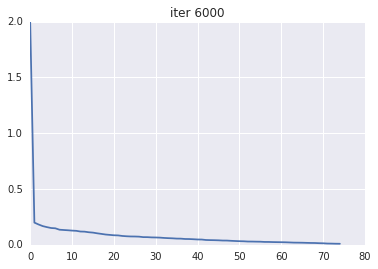

i = 8000, discriminant loss = 1.4099, generator loss =0.7207


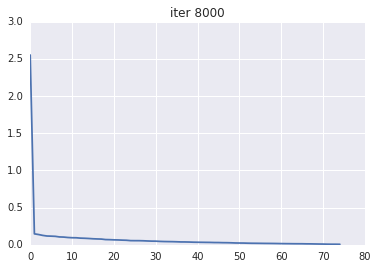

i = 10000, discriminant loss = 1.3981, generator loss =0.6962


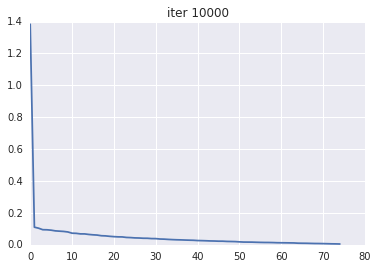

i = 12000, discriminant loss = 1.3667, generator loss =0.6888


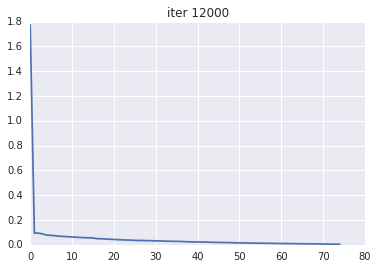

i = 14000, discriminant loss = 1.4222, generator loss =0.6577


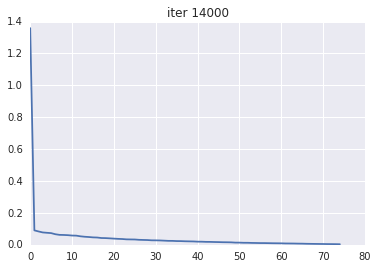

i = 16000, discriminant loss = 1.4261, generator loss =0.6325


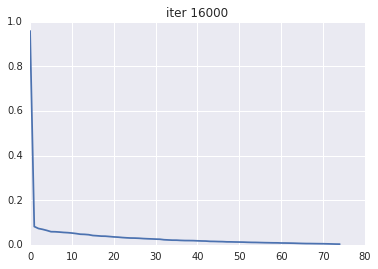

i = 18000, discriminant loss = 1.3976, generator loss =0.6802


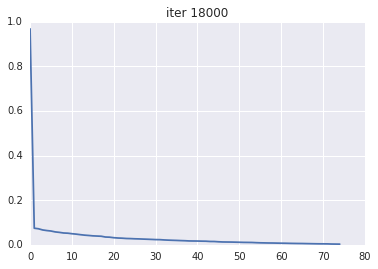

i = 20000, discriminant loss = 1.3880, generator loss =0.6984


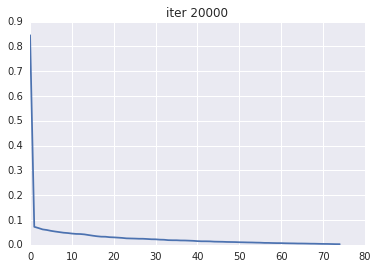

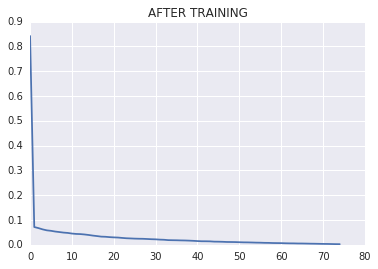

In [0]:
# Use plain RmsProp to optimise the GAN parameters.
# This experiment demonstrate how traditional GAN training fails to learn all
# the directions of a high dimensional Gaussian.
high_dim_gaussian_experiment('RMS')


SGA


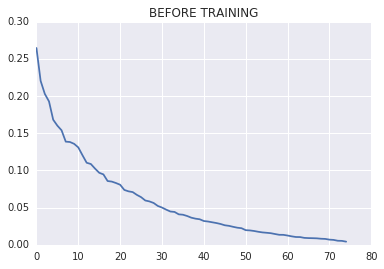

i = 0, discriminant loss = 1.3769, generator loss =0.7094


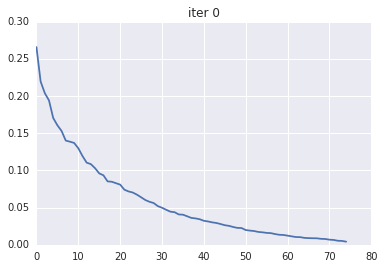

i = 2000, discriminant loss = 1.2849, generator loss =0.7615


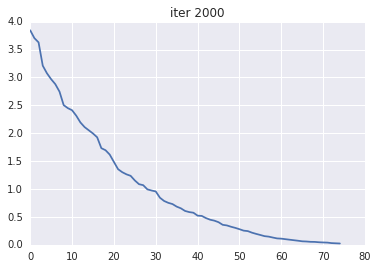

i = 4000, discriminant loss = 1.3325, generator loss =0.7163


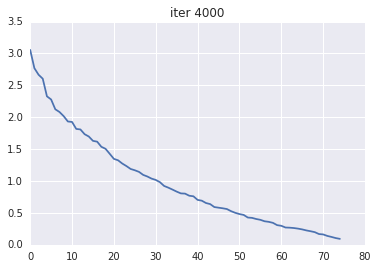

i = 6000, discriminant loss = 1.3726, generator loss =0.6905


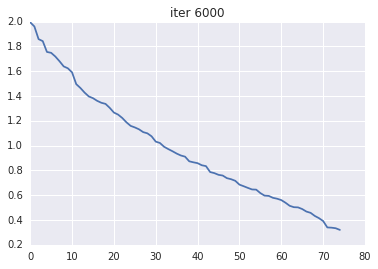

i = 8000, discriminant loss = 1.3845, generator loss =0.6966


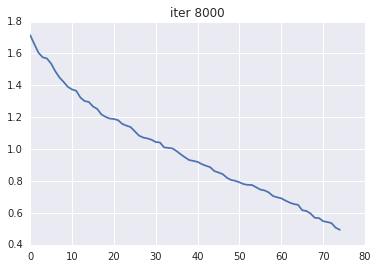

i = 10000, discriminant loss = 1.3752, generator loss =0.7032


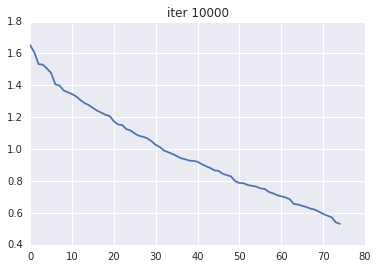

i = 12000, discriminant loss = 1.3732, generator loss =0.6984


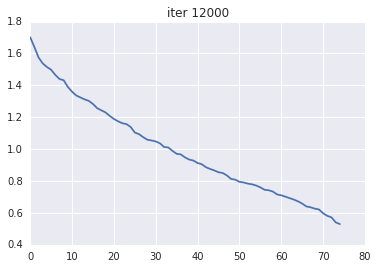

i = 14000, discriminant loss = 1.3646, generator loss =0.7025


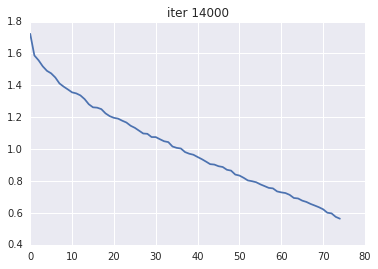

i = 16000, discriminant loss = 1.3579, generator loss =0.7128


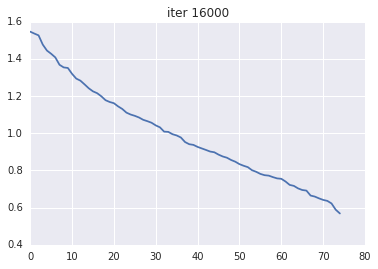

i = 18000, discriminant loss = 1.3672, generator loss =0.6974


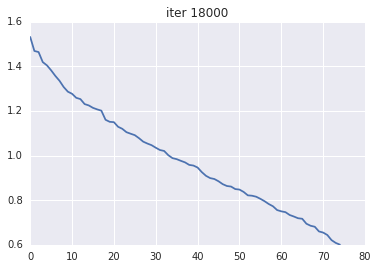

i = 20000, discriminant loss = 1.3701, generator loss =0.7050


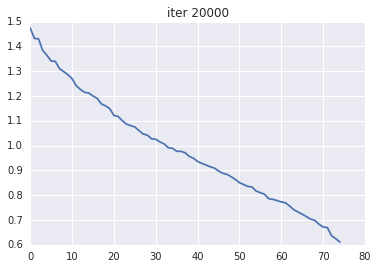

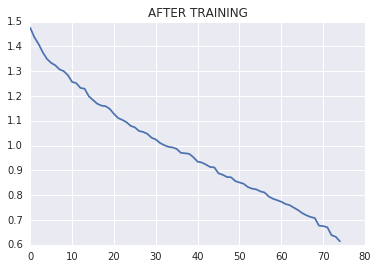

In [0]:
# Use Symplectic Gradient Adjustment to optimise the GAN parameters
high_dim_gaussian_experiment('SGA')
